# Prework

## Problem Statement:
It's common knowledge that state of the weather can have an impact on what people end up doing outside. We've been given a set of historical weather data, along side the amount of bike rentals that were issued for that given day. 
Our goal is to use the given data to help accurately predict what factors are influencing the rentals of bikes

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Data Acquisition

In [2]:
df = pd.read_csv('./data/day.csv')

Let's take a quick peak at the data to see what we are working with. 

In [3]:
df.sample(10,random_state =10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
566,567,2012-07-20,3,1,7,0,5,1,2,0.665833,0.613025,0.844167,0.208967,747,5123,5870
374,375,2012-01-10,1,1,1,0,2,1,1,0.308696,0.318826,0.646522,0.187552,173,3425,3598
181,182,2011-07-01,3,0,7,0,5,1,1,0.722500,0.652162,0.396250,0.102608,1246,4116,5362
529,530,2012-06-13,2,1,6,0,3,1,1,0.655833,0.611117,0.582083,0.343279,1173,6248,7421
233,234,2011-08-22,3,0,8,0,1,1,1,0.691667,0.638254,0.470000,0.276750,833,3925,4758
497,498,2012-05-12,2,1,5,0,6,0,1,0.564167,0.544817,0.480417,0.123133,2622,4807,7429
628,629,2012-09-20,3,1,9,0,4,1,1,0.546667,0.532192,0.618333,0.118167,939,6781,7720
417,418,2012-02-22,1,1,2,0,3,1,1,0.395833,0.392667,0.567917,0.234471,394,4379,4773
64,65,2011-03-06,1,0,3,0,0,0,2,0.376522,0.366252,0.948261,0.343287,114,491,605
163,164,2011-06-13,2,0,6,0,1,1,1,0.635000,0.601654,0.494583,0.305350,863,4157,5020


If we look at the columns, everything seems to be fairly self explanitory. Although 'wathersit' and the difference between 'temp' and 'atemp' could be a little more explicit. 
If you also look, almost all of the values are either encoded, or normalized which will be very handy when it comes to setting up a model. 


Let's check the doc's for the data and see what we're working with:


+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain 
        
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 

The other piece of data that can be explained a little more our the 3 target variables. 
-  causual: Amount of bike renters who were not registered before hand
-  registered: Amt of bike renters who were registered before hand
-  cnt: total bike renters (sum of previous two fields)

Since, most of our data is already normalized, we can almost begin exploring the data, but there are still some data preprocessing steps that need to be taken care of before we can jump right into that

## Data Preprocessing

The first thing I want to do with this data is go ahead and index it by the date, since we do have date times in our data

In [4]:
df.index = pd.to_datetime(df.dteday)
df.drop(columns='dteday',inplace=True)

For the sake of Exploration, let's also de-normalize our data, so we can get a stronger intuition for what the data is telling us. 
We can keep the normalized data seperate for now. 
To de-normalize our data, we will have to consult the readme, which contains the values we will need to transform our data back into it's original shape

- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)

In [5]:
transform_val={'temp':41,'atemp':50,'hum':100,'windspeed':67}
transformed_df = df.copy()
for field in transform_val:
    transformed_df[field] = transformed_df[field] * transform_val[field]

# Data Exploration + Feature Selection

## Rental Count

In [6]:
pd.concat([df.head(5),df.tail(5)])[['casual','registered','cnt']]

,casual,registered,cnt
dteday,,,
2011-01-01,331,654,985
2011-01-02,131,670,801
2011-01-03,120,1229,1349
2011-01-04,108,1454,1562
2011-01-05,82,1518,1600
2012-12-27,247,1867,2114
2012-12-28,644,2451,3095
2012-12-29,159,1182,1341
2012-12-30,364,1432,1796


Just looking at the first 5 and last 5 entries, we can see that the user counts seems to change. 
We can try to get a better idea of the changes by graphing the results 

Text(0.5, 1.0, 'User Count Daily')

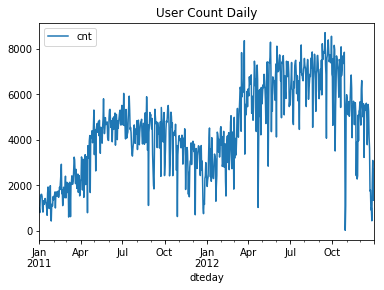

In [7]:
df[['cnt']].plot()
plt.title('User Count Daily')

Text(0.5, 1.0, 'User Count Monthly Averages')

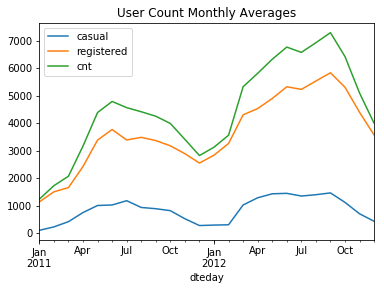

In [8]:
df.resample('M').mean()[['casual','registered','cnt']].plot()
plt.title('User Count Monthly Averages')

The userbase tends to flucuate the most depending on the month, although the most dramatic changes are definitely in the "Registered" users section (The group of people who are subscribed to the service)

There are also some deep spikes in the user count on particular days. Let's use our transformed dataset to take a look at some of the weather statistics for days that are not inline with the mean of that month that day is in. 

(tl;dr I'm going to check which day's user count is significantly lower than it's local mean)

In [9]:
count_df = df[['cnt']]

## Temperature

In [48]:

## Adds upper and lower count quantiles for finding which days have the lowest and highest usercount
count_df['monthly_q3'] = count_df['cnt'].resample('M').quantile(.85)
count_df['monthly_q1'] = count_df['cnt'].resample('M').quantile(.15)
count_df.fillna(method='backfill',inplace=True)

## Adds average temp for that month to each day to a dataframe called temp_df
temp_df = transformed_df[['cnt','temp','atemp']] 
temp_df['avg_temp'] = temp_df['temp'].resample('M').mean()
temp_df['avg_atemp'] = temp_df['atemp'].resample('M').mean()
temp_df.fillna(method='backfill',inplace=True)

/home/snorks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/snorks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/snorks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Text(0.5, 1.0, 'Low Rental Day Temp vs Avg Monthly Temp')

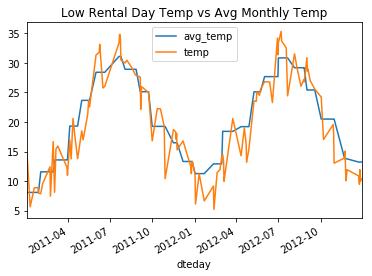

In [53]:
temp_df[count_df['monthly_q1'] > count_df['cnt']][['avg_temp','temp']].plot()
plt.title('Low Rental Day Temp vs Avg Monthly Temp')

If we examine this grap, it looks like days with lower temperatures tend to generate lower Rentals for that day. Along side some abnormally high temperatures also causing lower bike rentals for the day. Which is inline with what one may think when trying to guess the drivers of Bike Rentals

So, let's go ahead and start a list of feature's we will want to include in the model 

In [56]:
features = ['temp']

## Date

The next thing we should take a look at is the date, or more specifically, the change in date. 
Let's grab a graph of the rental count monthly averages vs date again

Text(0.5, 1.0, 'User Count Monthly Averages')

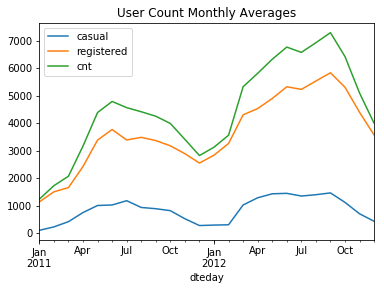

In [58]:
df.resample('M').mean()[['casual','registered','cnt']].plot()
plt.title('User Count Monthly Averages')

There is a fairly clear linear trend in the registered users (and thus overall count) that goes up as time moves forward. 


We can probably agree that the date is definitely a useful feature to have on the model. But currently our date is our time index, and we'll likely want to use in it's numeric form anyways. So, let's add another column that will be days from the start of data which will be the baseline. 

In [64]:
print(df.index.astype(int)[0])
print(df.index.astype(int)[1])
day_as_int = df.index.astype(int)[1] - df.index.astype(int)[0]
print(day_as_int)


1293840000000000000
1293926400000000000
86400000000000


So, we found what 1 day is equal to. Let's go ahead and use that to find the int representation of the first day

In [70]:
first_day_as_int = (df.index.astype(int)//day_as_int)[0]
print(first_day_as_int)

14975


Now we can use these two numbers to calculate the day field for each entry

In [71]:
(df.index.astype(int)//day_as_int) -14975

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            721, 722, 723, 724, 725, 726, 727, 728, 729, 730],
           dtype='int64', name='dteday', length=731)

Awesome! Now let's just apply that to a our dataframe as new field

In [72]:
df['day_from_start'] = (df.index.astype(int)//day_as_int) -14975

In [77]:
df[['day_from_start','cnt']].head()

,day_from_start,cnt
dteday,,
2011-01-01,0,985
2011-01-02,1,801
2011-01-03,2,1349
2011-01-04,3,1562
2011-01-05,4,1600


Before we fully decide on using this as a feature, let's just double check that our intution was correct. We'll use statistical tests to check the relationship between 'day_from_start' and bike rental count. 

In [81]:
from scipy.stats import pearsonr

In [82]:
pearsonr( df['day_from_start'], df['cnt'])

(0.6288302722083062, 1.0207631771174789e-81)

It definitely appears that there is a somewhat strong correlation between these two variables, but definitely not the only piece of the equation. I'd argue there is good reason to go ahead and add this to the list of features for our model

In [78]:
features.append('day_from_start')

## Humidity

Another factor to considere 